<a href="https://www.kaggle.com/code/mohamedbakrey/na-ve-bayes-and-logistic-regression-by-tensorflow?scriptVersionId=102324914" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1> <center> Instructions </center> </h1>

---

In this notebook, you will write code to develop a Naive Bayes classifier model to the Iris dataset using Distribution objects from TensorFlow Probability. You will also explore the connection between the Naive Bayes classifier and logistic regression.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line.

# Loading Pakage

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection
%matplotlib inline

# Loading Dataset
### about dataset:
---
Here we will use [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers.


In [6]:
# Load the dataset

iris = datasets.load_iris()

In [7]:
# Use only the first two features: sepal length and width

data = iris.data[:, :2]
targets = iris.target

In [13]:
print("The lenth of data",len(data))
print("Some of data:" ,data[:5])

The lenth of data 150
Some of data: [[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]]


#### Spliting Data

In [14]:
# Randomly shuffle the data and make train and test splits

x_train, x_test, y_train, y_test = model_selection.train_test_split(data, targets, test_size=0.2)

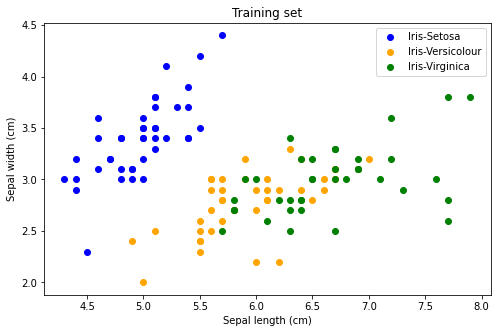

In [15]:
# Plot the training data

labels = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
label_colours = ['blue', 'orange', 'green']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()
    
plt.figure(figsize=(8, 5))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

# About Naive Bayes classifier


We will briefly review the Naive Bayes classifier model. The fundamental equation for this classifier is Bayes' rule:

$$
P(Y=y_k | X_1,\ldots,X_d) = \frac{P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}
$$

In the above, $d$ is the number of features or dimensions in the inputs $X$ (in our case $d=2$), and $K$ is the number of classes (in our case $K=3$). The distribution $P(Y)$ is the class prior distribution, which is a discrete distribution over $K$ classes. The distribution $P(X | Y)$ is the class-conditional distribution over inputs.

The Naive Bayes classifier makes the assumption that the data features $X_i$ are conditionally independent give the class $Y$ (the 'naive' assumption). In this case, the class-conditional distribution decomposes as

$$
\begin{align}
P(X | Y=y_k) &= P(X_1,\ldots,X_d | Y=y_k)\\
&= \prod_{i=1}^d P(X_i | Y=y_k)
\end{align}
$$

This simplifying assumption means that we typically need to estimate far fewer parameters for each of the distributions $P(X_i | Y=y_k)$ instead of the full joint distribution $P(X | Y=y_k)$.

Once the class prior distribution and class-conditional densities are estimated, the Naive Bayes classifier model can then make a class prediction $\hat{Y}$ for a new data input $\tilde{X} := (\tilde{X}_1,\ldots,\tilde{X}_d)$ according to

$$
\begin{align}
\hat{Y} &= \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) \\
&= \text{argmax}_{y_k}\frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}\\
&= \text{argmax}_{y_k} P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)
\end{align}
$$

#### Define the class prior distribution
 
We will begin by defining the class prior distribution. To do this we will simply take the maximum likelihood estimate, given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

where the superscript $(n)$ indicates the $n$-th dataset example, $\delta(Y^{(n)}=y_k) = 1$ if $Y^{(n)}=y_k$ and 0 otherwise, and $N$ is the total number of examples in the dataset. The above is simply the proportion of data examples belonging to class $k$.

In [16]:

def get_prior(y):
   
    probs = np.unique(y, return_counts=True)[1] / len(y)
    distribution = tfd.Categorical(probs=probs)
    return distribution

In [17]:
# Run your function to get the prior

prior = get_prior(y_train)

2022-08-02 08:23:30.215841: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


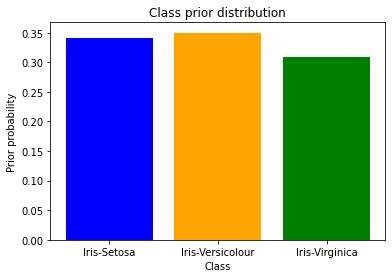

In [18]:
# Plot the prior distribution

labels = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
plt.bar([0, 1, 2], prior.probs.numpy(), color=label_colours)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1, 2], labels)
plt.show()

#### Define the class-conditional densities

We now turn to the definition of the class-conditional distributions $P(X_i | Y=y_k)$ for $i=0, 1$ and $k=0, 1, 2$. In our model, we will assume these distributions to be univariate Gaussian:

$$
\begin{align}
P(X_i | Y=y_k) &= N(X_i | \mu_{ik}, \sigma_{ik})\\
&= \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left\{-\frac{1}{2} \left(\frac{x - \mu_{ik}}{\sigma_{ik}}\right)^2\right\}
\end{align}
$$
with mean parameters $\mu_{ik}$ and standard deviation parameters $\sigma_{ik}$, twelve parameters in all. We will again estimate these parameters using maximum likelihood. In this case, the estimates are given by

$$
\begin{align}
\hat{\mu}_{ik} &= \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
\hat{\sigma}^2_{ik} &= \frac{\sum_n (X_i^{(n)} - \hat{\mu}_{ik})^2 \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)}
\end{align}
$$

Note that the above are just the means and variances of the sample data points for each class.

In [19]:
def get_class_conditionals(x, y):
    counts = np.zeros(3)
    loc = np.zeros((3, 2))
    scale_diag = np.zeros((3, 2))
    for i in range(2):
        for c_k in range(3):
            counts[c_k] = np.sum(np.where(y==c_k))
            loc[c_k, i] = np.mean(x[np.where(y==c_k), i])
            scale_diag[c_k, i] = np.std(x[np.where(y==c_k), i])
    distribution = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
    
    return distribution

In [21]:
# Run your function to get the class-conditional distributions

class_conditionals = get_class_conditionals(x_train, y_train)
class_conditionals

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float64>

We can visualise the class-conditional densities with contour plots by running the cell below. Notice how the contours of each distribution correspond to a Gaussian distribution with diagonal covariance matrix, since the model assumes that each feature is independent given the class.

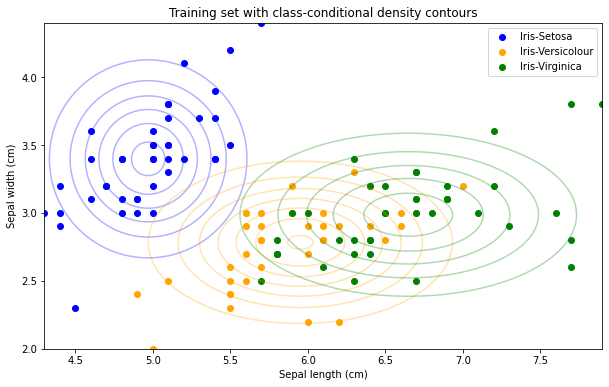

In [22]:
# Plot the training data with the class-conditional density contours

def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, prob_fn, batch_shape, colours, levels=None, num_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = prob_fn(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1))
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], colors=colours[batch], alpha=0.3)

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.prob, 3, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

#### Make predictions from the model

Now the prior and class-conditional distributions are defined, you can use them to compute the model's class probability predictions for an unknown test input $\tilde{X} = (\tilde{X}_1,\ldots,\tilde{X}_d)$, according to

$$
P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) = \frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}
$$

The class prediction can then be taken as the class with the maximum probability:

$$
\hat{Y} = \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d)
$$

In [23]:

def predict_class(prior, class_conditionals, x):

    class_probs = class_conditionals.log_prob(x[:, None])
    joint_likelihood = tf.add(tf.cast(class_probs, dtype=tf.float64), tf.math.log(prior.probs)[tf.newaxis, ...])
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor
    y = np.argmax(np.exp(log_prob), axis=-1)
    return y

In [25]:
# Get the class predictions

predictions = predict_class(prior, class_conditionals, x_test)
print("The predictions", predictions)

The predictions [1 0 2 2 1 2 1 2 0 2 1 0 1 0 0 1 1 2 0 2 1 0 1 1 2 0 2 2 0 0]


In [26]:
# Evaluate the model accuracy on the test set

accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 0.7667


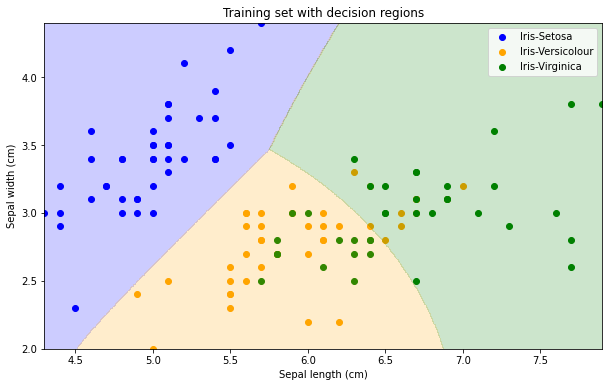

In [27]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior, class_conditionals, x), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

### Binary classifier

We will now draw a connection between the Naive Bayes classifier and logistic regression.

First, we will update our model to be a binary classifier. In particular, the model will output the probability that a given input data sample belongs to the 'Iris-Setosa' class: $P(Y=y_0 | \tilde{X}_1,\ldots,\tilde{X}_d)$. The remaining two classes will be pooled together with the label $y_1$.

In [29]:
# Redefine the dataset to have binary labels

y_train_binary = np.array(y_train)
y_train_binary[np.where(y_train_binary == 2)] = 1

y_test_binary = np.array(y_test)
y_test_binary[np.where(y_test_binary == 2)] = 1

In [33]:
print("Some of train data:", y_train_binary)
print("***************************************")
print("Some of test data",y_test_binary)


Some of train data: [1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1
 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1
 1 1 0 0 0 1 0 1 0]
***************************************
Some of test data [1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0]


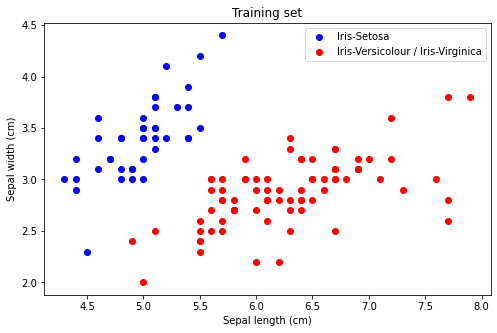

In [34]:
# Plot the training data

labels_binary = {0: 'Iris-Setosa', 1: 'Iris-Versicolour / Iris-Virginica'}
label_colours_binary = ['blue', 'red']

plt.figure(figsize=(8, 5))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
plt.show()

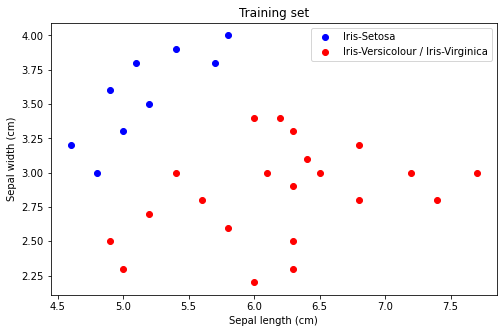

In [35]:
# Plot the testing data

labels_binary = {0: 'Iris-Setosa', 1: 'Iris-Versicolour / Iris-Virginica'}
label_colours_binary = ['blue', 'red']

plt.figure(figsize=(8, 5))
plot_data(x_test, y_test_binary, labels_binary, label_colours_binary)
plt.show()

We will also make an extra modelling assumption that for each class $k$, the class-conditional distribution $P(X_i | Y=y_k)$ for each feature $i=0, 1$, has standard deviation $\sigma_i$, which is the same for each class $k$. 

This means there are now six parameters in total: four for the means $\mu_{ik}$ and two for the standard deviations $\sigma_i$ ($i, k=0, 1$). 

We will again use maximum likelihood to estimate these parameters. The prior distribution will be as before, with the class prior probabilities given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

We will use your previous function `get_prior` to redefine the prior distribution.

In [37]:
# Redefine the prior

prior_binary = get_prior(y_train_binary)
prior_binary

<tfp.distributions.Categorical 'Categorical' batch_shape=[] event_shape=[] dtype=int32>

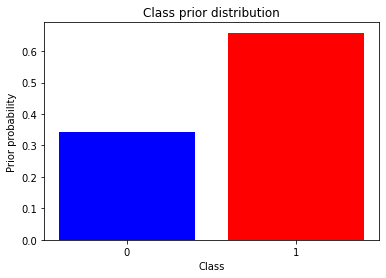

In [38]:
# Plot the prior distribution

plt.bar([0, 1], prior_binary.probs.numpy(), color=label_colours_binary)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1], labels_binary)
plt.show()

For the class-conditional densities, the maximum likelihood estimate for the means are again given by

$$
\hat{\mu}_{ik} = \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
$$

However, the estimate for the standard deviations $\sigma_i$ is updated. There is also a closed-form solution for the shared standard deviations, but we will instead learn these from the data.

In [40]:
def learn_stdevs(x, y, scales, optimiser, epochs):
    n_classes = len(np.unique(y))
    n_features = x.shape[-1]
    loc = np.zeros((n_classes, n_features), dtype=np.float32)
    
    for f in range(n_features):
        for c in range(n_classes):
            samples = x[y==c][:, f]
            loc[c, f] = np.mean(samples)
    
    distribution = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scales)
    x_reshape = np.expand_dims(x.astype(np.float32), 1)
    
    def nll(x, y, distribution):
        predictions = - distribution.log_prob(x)
        probs = []
        for c_k in range(n_classes):
            probs.append(tf.reduce_sum(predictions[y == c_k][:, c_k]))
        return tf.reduce_sum(probs)
    
    @tf.function
    def get_loss_and_grads(x, distribution):
        with tf.GradientTape() as tape:
            tape.watch(distribution.trainable_variables)
            loss = nll(x, y, distribution)
            
        grads = tape.gradient(loss, distribution.trainable_variables)
        return loss, grads
    
    train_loss_results = []
    train_scale_results = []
    
    for epoch in range(epochs):
        loss, grads = get_loss_and_grads(x_reshape, distribution)
        optimiser.apply_gradients(zip(grads, distribution.trainable_variables))
        train_loss_results.append(loss)
        train_scale_results.append(distribution.parameters['scale_diag'].numpy())
        
        if epoch % 100 == 0:
            print(f'epoch: {epoch}, Loss: {loss}')
    
    return np.array(train_loss_results), np.array(train_scale_results), distribution
    

In [41]:
# Define the inputs to your function

scales = tf.Variable([1., 1.])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
epochs = 500

In [42]:
# Run your function to learn the class-conditional standard deviations

nlls, scales_arr, class_conditionals_binary = learn_stdevs(x_train, y_train_binary, scales, opt, epochs)

2022-08-02 08:34:09.562560: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-02 08:34:09.996228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


epoch: 0, Loss: 246.19598388671875
epoch: 100, Loss: 142.54690551757812
epoch: 200, Loss: 142.48123168945312
epoch: 300, Loss: 142.48121643066406
epoch: 400, Loss: 142.481201171875


In [43]:
# View the distribution parameters

print("Class conditional means:")
print(class_conditionals_binary.loc.numpy())
print("\nClass conditional standard deviations:")
print(class_conditionals_binary.stddev().numpy())

Class conditional means:
[[4.9707317 3.397561 ]
 [6.278481  2.878481 ]]

Class conditional standard deviations:
[[0.5548144 0.3459669]
 [0.5548144 0.3459669]]


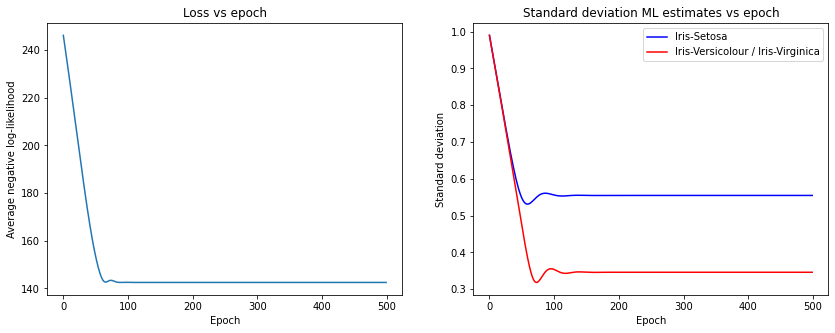

In [44]:
# Plot the loss and convergence of the standard deviation parameters

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(nlls)
ax[0].set_title("Loss vs epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Average negative log-likelihood")
for k in [0, 1]:
    ax[1].plot(scales_arr[:, k], color=label_colours_binary[k], label=labels_binary[k])
ax[1].set_title("Standard deviation ML estimates vs epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Standard deviation")
plt.legend()
plt.show()

We can also plot the contours of the class-conditional Gaussian distributions as before, this time with just binary labelled data. Notice the contours are the same for each class, just with a different centre location.

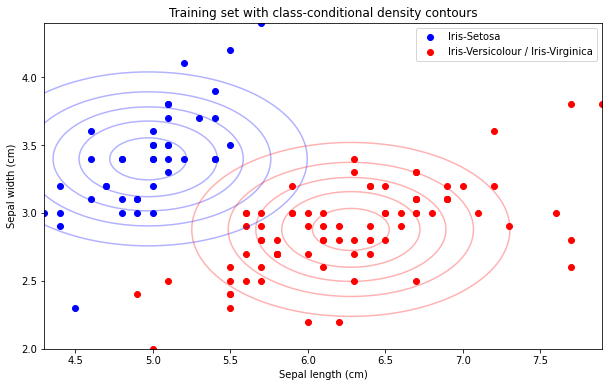

In [45]:
# Plot the training data with the class-conditional density contours

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals_binary.prob, 2, label_colours_binary)
plt.title("Training set with class-conditional density contours")
plt.show()

We can also plot the decision regions for this binary classifier model, notice that the decision boundary is now linear.

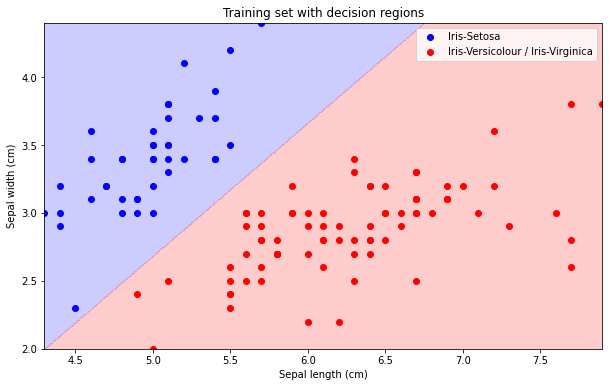

In [46]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior_binary, class_conditionals_binary, x), 
             1, label_colours_binary, levels=[-0.5, 0.5, 1.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

#### Link to logistic regression

In fact, we can see that our predictive distribution $P(Y=y_0 | X)$ can be written as follows:


$$
\begin{align}
P(Y=y_0 | X) =& ~\frac{P(X | Y=y_0)P(Y=y_0)}{P(X | Y=y_0)P(Y=y_0) + P(X | Y=y_1)P(Y=y_1)}\\
=&  ~\frac{1}{1 + \frac{P(X | Y=y_1)P(Y=y_1)}{P(X | Y=y_0)P(Y=y_0)}}\\
=& ~\sigma(a)
\end{align}
$$

where $\sigma(a) = \frac{1}{1 + e^{-a}}$ is the sigmoid function, and $a = \log\frac{P(X | Y=y_0)P(Y=y_0)}{P(X | Y=y_1)P(Y=y_1)}$ is the _log-odds_.

With our additional modelling assumption of a shared covariance matrix $\Sigma$, it can be shown (using the Gaussian pdf) that $a$ is in fact a linear function of $X$: 

$$
a = w^T X + w_0
$$

where

$$
\begin{align}
w =& ~\Sigma^{-1} (\mu_0 - \mu_1)\\
w_0 =& -\frac{1}{2}\mu_0^T \Sigma^{-1}\mu_0 + \frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1 + \log\frac{P(Y=y_0)}{P(Y=y_1)}
\end{align}
$$

The model therefore takes the form $P(Y=y_0 | X) = \sigma(w^T X + w_0)$, with weights $w\in\mathbb{R}^2$ and bias $w_0\in\mathbb{R}$. This is the form used by logistic regression, and explains why the decision boundary above is linear. 

In the above we have outlined the derivation of the generative logistic regression model. The parameters are typically estimated with maximum likelihood, as we have done. 

In [47]:
def get_logistic_regression_params(prior, class_conditionals):
   
    mu0 = class_conditionals.parameters['loc'][0]
    mu1 = class_conditionals.parameters['loc'][1]
    
    cov = np.linalg.inv(class_conditionals.covariance())
  
    print(cov.shape)
    w = np.matmul(cov, (mu0 - mu1))
    w0 = - 0.5 * (np.matmul(np.transpose(mu0), np.matmul(cov, mu0)))\
         + 0.5 * (np.matmul(np.transpose(mu1), np.matmul(cov, mu1)))\
         + np.log(prior.parameters['probs'][0] / prior.parameters['probs'][1])
    return w, w0

In [48]:
# Run your function to get the logistic regression parameters

w, w0 = get_logistic_regression_params(prior_binary, class_conditionals_binary)

(2, 2, 2)


## Thanks